# Steps for running on Anaconda

In [1]:
#STEPS FOR RUNNING ON ANACONDA

#These only need to be done once. We suggest running this notebook in a new anaconda environment.
#Steps below are commented out since they only need to be done once. You may need to restart environment after installing.

#!git clone https://github.com/ultralytics/yolov5  # clone repo
#%cd yolov5
#%pip install -qr requirements.txt
#%pip install wandb

# Steps for running on Jetson

# Code

In [2]:
import cv2
import torch
import os
import shutil
import time
import numpy as np
import pandas as pd
from playsound import playsound
from IPython.display import Image, clear_output  # to display images

print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

Setup complete. Using torch 1.11.0 (NVIDIA GeForce GTX 1080 Ti)


In [8]:
# Model
#weightpath = 'weights/best2_480_full_v3.pt' #without action camera video training examples
weightpath = 'weights/best2_480_full_v33.pt' #With action camera video training examples

model = torch.hub.load('ultralytics/yolov5', 'custom', path=weightpath, force_reload=True)

Downloading: "https://github.com/ultralytics/yolov5/archive/master.zip" to C:\Users\thwang99/.cache\torch\hub\master.zip
YOLOv5  2022-8-4 Python-3.8.13 torch-1.11.0 CUDA:0 (NVIDIA GeForce GTX 1080 Ti, 11264MiB)

Fusing layers... 
Model summary: 213 layers, 7045186 parameters, 0 gradients
Adding AutoShape... 


In [9]:
#Plays a sound in background
playstarttime = 0

def playAlarm():
    global playstarttime
    
    if (time.time() - playstarttime > 2):
        playsound("alarm.mp3", block=False)
        playstarttime = time.time()

In [10]:
def runOnWebcam():
    cap = cv2.VideoCapture(0)
    return runHelper(cap)

def runOnFile(filepath):
    cap = cv2.VideoCapture(filepath)
    
    return runHelper(cap)

def runHelper(cap):
    '''Runs detection on cap video capture. Closes and destroyes windows after.'''
    sc = 0 # screenshot

    #Start with nothing detected state.
    timeLastNoDetect = time.time() #No detections or safe driving detected
    timeLastYesDetect = 0
    potential_detection = False
    timePotentialDetection = 0
    
    detected_class_current = 0
    
    detected_1_count = 0
    detected_2_count = 0
    
    last_print_time = 0

    #Running totals, used to determine what to return.
    detected_something = False
    detected_1_count_total = 0
    detected_2_count_total = 0
    
    #Tunables for the model.
    min_detect_time = 1.5
    seconds_between_reset = 0.5
    
    while cap.isOpened():
        ret, frame = cap.read()

        if frame is None:
            break

        # Make detections 
        results = model(frame, size=480)

        # print result
        sc += 1
        info = results.pandas().xyxy[0]
        
        cycle_count = 0

        timenow = time.time()
        if len(info) == 0 or info['class'].values[0] == 0: # no detection or safe driving detected
            timeLastNoDetect = time.time()
            if timenow-timeLastYesDetect>seconds_between_reset:
                potential_detection = False
                detected_class_current = 0
                detected_1_count = 0
                detected_2_count = 0
                if timenow-last_print_time > 1:
                    print("Safe driving...")
                    last_print_time = time.time()
        else: # detected something other than safe driving
            timeLastYesDetect = time.time()
            if potential_detection == False:
                potential_detection = True
                timePotentialDetection = time.time()
            detected_time_length = timenow-timePotentialDetection
            
            if info['class'].values[0] > 0 and info['class'].values[0] <= 7:
                detected_1_count = detected_1_count + 1
            elif info['class'].values[0] > 7:
                detected_2_count = detected_2_count + 1
            else:
                print("ERROR, should never see this message.")
            
            if(detected_time_length>min_detect_time):
                detected_something = True
                if detected_1_count > detected_2_count:
                    detected_class_current = 1
                    detected_1_count_total = detected_1_count_total + 1
                    if timenow-last_print_time > 1:
                        print("Distracted Driver Detected...{}..{}s".format(info['name'].values[0],detected_time_length))
                        playAlarm()
                        last_print_time = time.time()
                else:
                    detected_class_current = 2
                    detected_2_count_total = detected_2_count_total + 1
                    if timenow-last_print_time > 1:
                        print("Drowsy Driver Detected...{}..{}s".format(info['name'].values[0],detected_time_length))
                        playAlarm()
                        last_print_time = time.time()

        # show class on the captured image
        cv2.imshow('YOLO', np.squeeze(results.render()))

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    
    cap.release()
    cv2.destroyAllWindows()
    
    if detected_something:
        if detected_1_count_total > detected_2_count_total:
            return 1
        else:
            return 2
    
    return 0

In [31]:
#RUN CONTINUOUSLY by running this cell
runOnWebcam()

Distracted Driver Detected...c5 - Reaching Behind..1.5269622802734375s
Distracted Driver Detected...c5 - Reaching Behind..2.995920181274414s
Safe driving...
Safe driving...
Safe driving...
Safe driving...
Distracted Driver Detected...c5 - Reaching Behind..1.5376226902008057s
Distracted Driver Detected...c6 - Hair and Makeup..2.6824071407318115s
Distracted Driver Detected...c6 - Hair and Makeup..3.6949188709259033s


1

In [11]:
#RUN SYSTEM TEST by running this cell and cell below

#Must have trailing path seperator
testVidsFolderPath="../testvids/"

#Process classes.txt
classesFilePath = testVidsFolderPath + "classes.txt"

results_df = pd.DataFrame(columns=['filepath', 'expected', 'detected'])

curr_class = 0
directory = testVidsFolderPath + str(curr_class)
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    result_detect = runOnFile(f)
    results_df.loc[len(results_df.index)] = [f, curr_class, result_detect]
    print("File: [{}], detect: [{}]".format(f, result_detect))
    
curr_class = 1
directory = testVidsFolderPath + str(curr_class)
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    result_detect = runOnFile(f)
    results_df.loc[len(results_df.index)] = [f, curr_class, result_detect]
    print("File: [{}], detect: [{}]".format(f, result_detect))
    
curr_class = 2
directory = testVidsFolderPath + str(curr_class)
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    result_detect = runOnFile(f)
    results_df.loc[len(results_df.index)] = [f, curr_class, result_detect]
    print("File: [{}], detect: [{}]".format(f, result_detect))
    
print(results_df)

Drowsy Driver Detected...d2 - Nodding Off..1.5180270671844482s
Drowsy Driver Detected...d2 - Nodding Off..2.6298258304595947s
Drowsy Driver Detected...d2 - Nodding Off..3.6684648990631104s
Drowsy Driver Detected...d2 - Nodding Off..4.713238716125488s
Drowsy Driver Detected...d2 - Nodding Off..5.821863174438477s
Safe driving...
File: [../testvids/0\0-safe-driving-tony-001.mp4], detect: [2]
Safe driving...
Safe driving...
Distracted Driver Detected...c5 - Reaching Behind..1.5009441375732422s
Safe driving...
Safe driving...
Safe driving...
File: [../testvids/0\0-safe-driving-tony-002.mp4], detect: [1]
Drowsy Driver Detected...d2 - Nodding Off..1.5350584983825684s
Drowsy Driver Detected...d2 - Nodding Off..2.6675612926483154s
Drowsy Driver Detected...d2 - Nodding Off..3.691206932067871s
Drowsy Driver Detected...d2 - Nodding Off..4.70641016960144s
Drowsy Driver Detected...d2 - Nodding Off..5.737900972366333s
File: [../testvids/0\0-safe-driving-tony-003.mp4], detect: [2]
Safe driving...
Safe

Drowsy Driver Detected...d2 - Nodding Off..2.57967209815979s
Drowsy Driver Detected...d2 - Nodding Off..3.599449396133423s
Drowsy Driver Detected...d2 - Nodding Off..4.6412672996521s
Safe driving...
File: [../testvids/1\1-texting-tony-005.mp4], detect: [2]
Safe driving...
Safe driving...
Drowsy Driver Detected...d0 - Eyes Closed..1.5219733715057373s
Safe driving...
Safe driving...
Safe driving...
File: [../testvids/2\2-eyesclosed-tony-001.mp4], detect: [2]
Safe driving...
Distracted Driver Detected...d0 - Eyes Closed..1.6496706008911133s
Drowsy Driver Detected...d0 - Eyes Closed..2.719841480255127s
Safe driving...
Safe driving...
Distracted Driver Detected...d0 - Eyes Closed..1.8928852081298828s
File: [../testvids/2\2-eyesclosed-tony-002.mp4], detect: [1]
Safe driving...
Safe driving...
Safe driving...
Drowsy Driver Detected...d0 - Eyes Closed..1.51255464553833s
Drowsy Driver Detected...d0 - Eyes Closed..2.719224452972412s
Drowsy Driver Detected...d2 - Nodding Off..3.80586576461792s
Fi

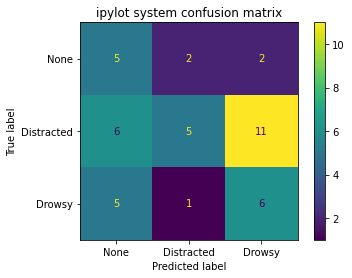

In [12]:
%matplotlib inline

from sklearn.metrics import confusion_matrix

cf_matrix = confusion_matrix(results_df['expected'], results_df['detected'])

import tkinter
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(results_df['expected'], results_df['detected'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = ['None', 'Distracted', 'Drowsy'])
disp.plot()
disp.ax_.set_title("ipylot system confusion matrix")

plt.show()